# The time evolution of Rabi Hamiltonian

In [1]:
# Frount matter
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as la


#If your screen has retina display this will increase resolution of plots
%config InlineBackend.figure_format = 'retina'

with open("psi.pickle", "rb") as f0:
    psi = pickle.load(f0)
with open("E.pickle", "rb") as f1:
    E = pickle.load(f1)

In [2]:
# Basic constants and parameters
# grid points
N=2000

# spatial grid
XMin=-50
XMax=50
X=np.linspace(XMin, XMax, N)
X2=np.linspace(XMin, XMax, 2*N)

# momentum grid
P=(2*np.pi/(XMax-XMin))*np.concatenate((np.arange(0,N//2), np.arange(-N//2,0)))

# initial and final conditions
w0=0.35
w1=1

#define pauli matrixes
S0 = np.array([[1, 0], [0, 1]])
S1 = np.array([[0, 1], [1, 0]])
S3 = np.array([[1, 0], [0, -1]])

## Time operator

In [3]:
def simulation(a,b,v,tau,dt):
    M = int(tau/dt)
    psi_0 = psi[0,a,b][v]
    psi_1 = np.zeros(2*N, dtype=np.complex128)
    psi_2 = np.zeros(2*N, dtype=np.complex128)
    psi_3 = np.zeros(2*N, dtype=np.complex128)

    UT = np.exp(-1j*(P**2/2)*dt/2)

    for m in range(M+1):
        # momentum 1/2 update
        # saperate spin up and down
        psi_0_up = psi_0[::2]    
        phi_0_up = np.fft.fft(psi_0_up) 
        phi_1_up = UT*phi_0_up
        psi_1_up = np.fft.ifft(phi_1_up)

        psi_0_down=psi_0[1::2]
        phi_0_down = np.fft.fft(psi_0_down)
        phi_1_down= UT*phi_0_down
        psi_1_down=np.fft.ifft(phi_1_down)

        psi_1[::2] = psi_1_up
        psi_1[1::2] = psi_1_down

        w= w0+((w1-w0)/M)*m
        Vcase = np.einsum('i,jk->ijk', (w*X)**2/2, S0) + np.einsum('i,jk->ijk', a*X, S1) + b*S3
        UV = la.expm(-1j*Vcase*0.25)
        psi_2 = np.einsum('ijk,ik->ij', UV, psi_1.reshape(-1, 2))
        psi_2 = psi_2.reshape(-1)
        
        # momentum 1/2 update
        # saperate spin up and down
        psi_2_up = psi_2[::2]    
        phi_2_up = np.fft.fft(psi_2_up) 
        phi_3_up = UT*phi_2_up
        psi_3_up = np.fft.ifft(phi_3_up)

        psi_2_down=psi_2[1::2]
        phi_2_down = np.fft.fft(psi_2_down)
        phi_3_down= UT*phi_2_down
        psi_3_down=np.fft.ifft(phi_3_down)

        # combine up and down
        psi_3[::2] = psi_3_up
        psi_3[1::2] = psi_3_down

        psi_0 = psi_3
    return psi_0

In [4]:
# Partition function
def Z(w,a,b,n,beta):
    Z_0=0
    for v in range(n):
        energy = E[w, a, b][v]
        Z_0 += np.exp(-beta * energy)  
    return Z_0

# Helmholtz free energy difference
def delta_F(a,b,n,beta):
    delta_F_0=1/beta*np.log(Z(0,a,b,n,beta)/Z(1,a,b,n,beta))
    return delta_F_0

In [5]:
def var(a,b,n,tau,dt,beta):
    Fm=0.0
    Sm=0.0
    Z0= Z(0,a,b,n,beta)
    DF= delta_F(a,b,n,beta)
    for i in range(n):
        for j in range(n):
            psi_t=simulation(a,b,i,tau,dt)
            psi1=psi[1,a,b][j]
            abs_dot=np.abs(np.dot(psi1,psi_t))**2
            Fm+=np.exp(-beta*E[1,a,b][j])*abs_dot/Z0
            Sm+=np.exp(-beta*(2*E[1,a,b][j]-E[0,a,b][i]))*abs_dot/Z0
    Var=Sm-Fm**2
    Var_dis=Var/np.exp(-2*beta*DF)
    return Var_dis

In [8]:
print(var(5,5,50,5,0.25,4))

6352.878933181945


## Store

In [7]:
n=200
# Add new data 
psit_store = {}
# Add new data
for a in [0, 0.25, 0.5, 0.75, 1, 5]:
    for b in [0, 0.25, 0.5, 0.75, 1, 5]:
        for v in range(n):
            for tau in [5,10,50,100,1000]:
                key = (a, b, v, tau)
                psit_store[key] = simulation(a, b, v, tau, 0.25)

# Save the updated data
with open("simulation.pickle", "wb") as f2:
    pickle.dump(psit_store, f2)

## Check out

In [8]:
# Read data
with open("simulation.pickle", "rb") as f2:
    psit = pickle.load(f2)

In [9]:
# Key ranges
keys = list(psit.keys())
name=['a','b','v','tau']
for i in range(4):
    chars = [key[i] for key in keys]
    chars = list(set(chars))
    chars.sort()
    print(f"{name[i]}: {chars}")

a: [0, 0.25, 0.5, 0.75, 1, 5]
b: [0, 0.25, 0.5, 0.75, 1, 5]
v: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
tau: [5, 10, 50, 100, 1000]


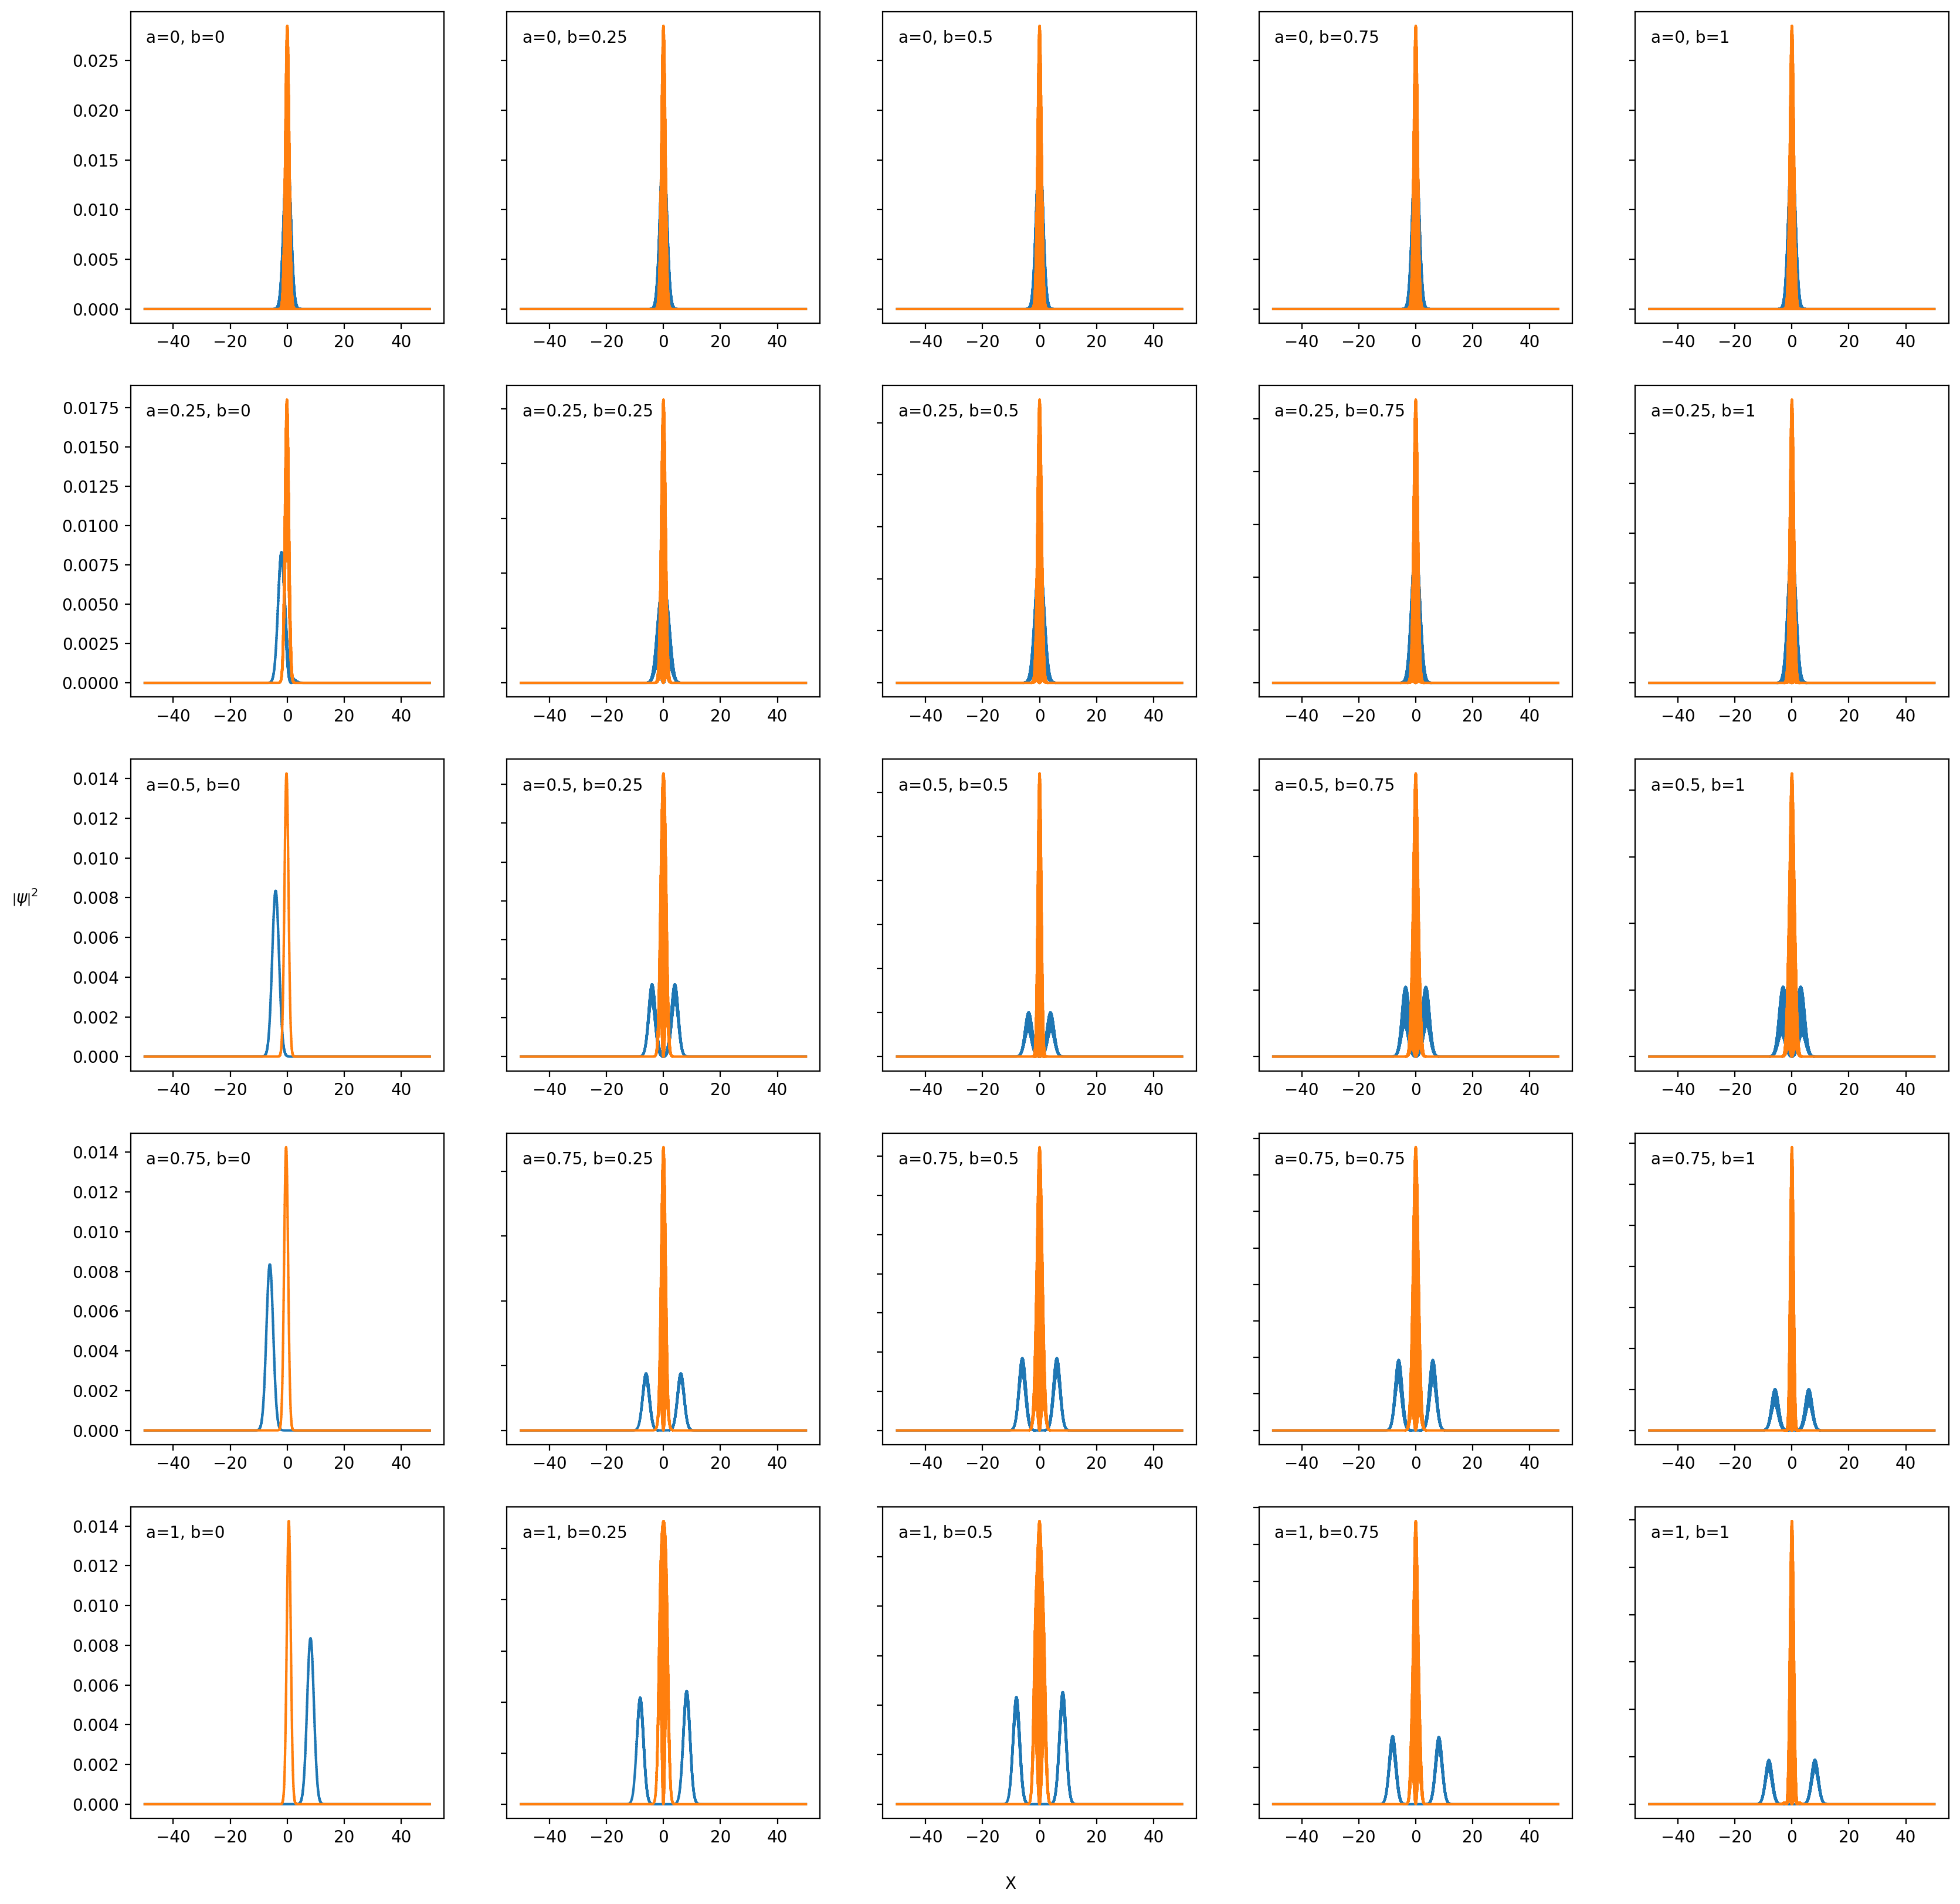

In [10]:
# spin up
def plot_graph(ax, a, b, v):
    ax.plot(X2, np.abs(psi[0,a,b][v])**2) 
    ax.plot(X2, np.abs(psit[a,b,v,100])**2)
    ax.text(0.05, 0.9, f'a={a}, b={b}', transform=ax.transAxes)

fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    
list=[0,0.25,0.5,0.75,1]
for i in range(5):
    for j in range(5):
        a = list[i]
        b = list[j]
        plot_graph(axs[i, j], a, b, 0)
        if j > 0: # remove y-axis labels for all subplots except the leftmost column
            axs[i, j].set_yticklabels([])
    # axs[i, 0].set_ylabel('$\\left|\\psi\\right|^2$')

fig.text(0.5, 0.08, 'X', ha='center')
fig.text(0.08, 0.5, '$\\left|\\psi\\right|^2$', ha='center')


plt.show()

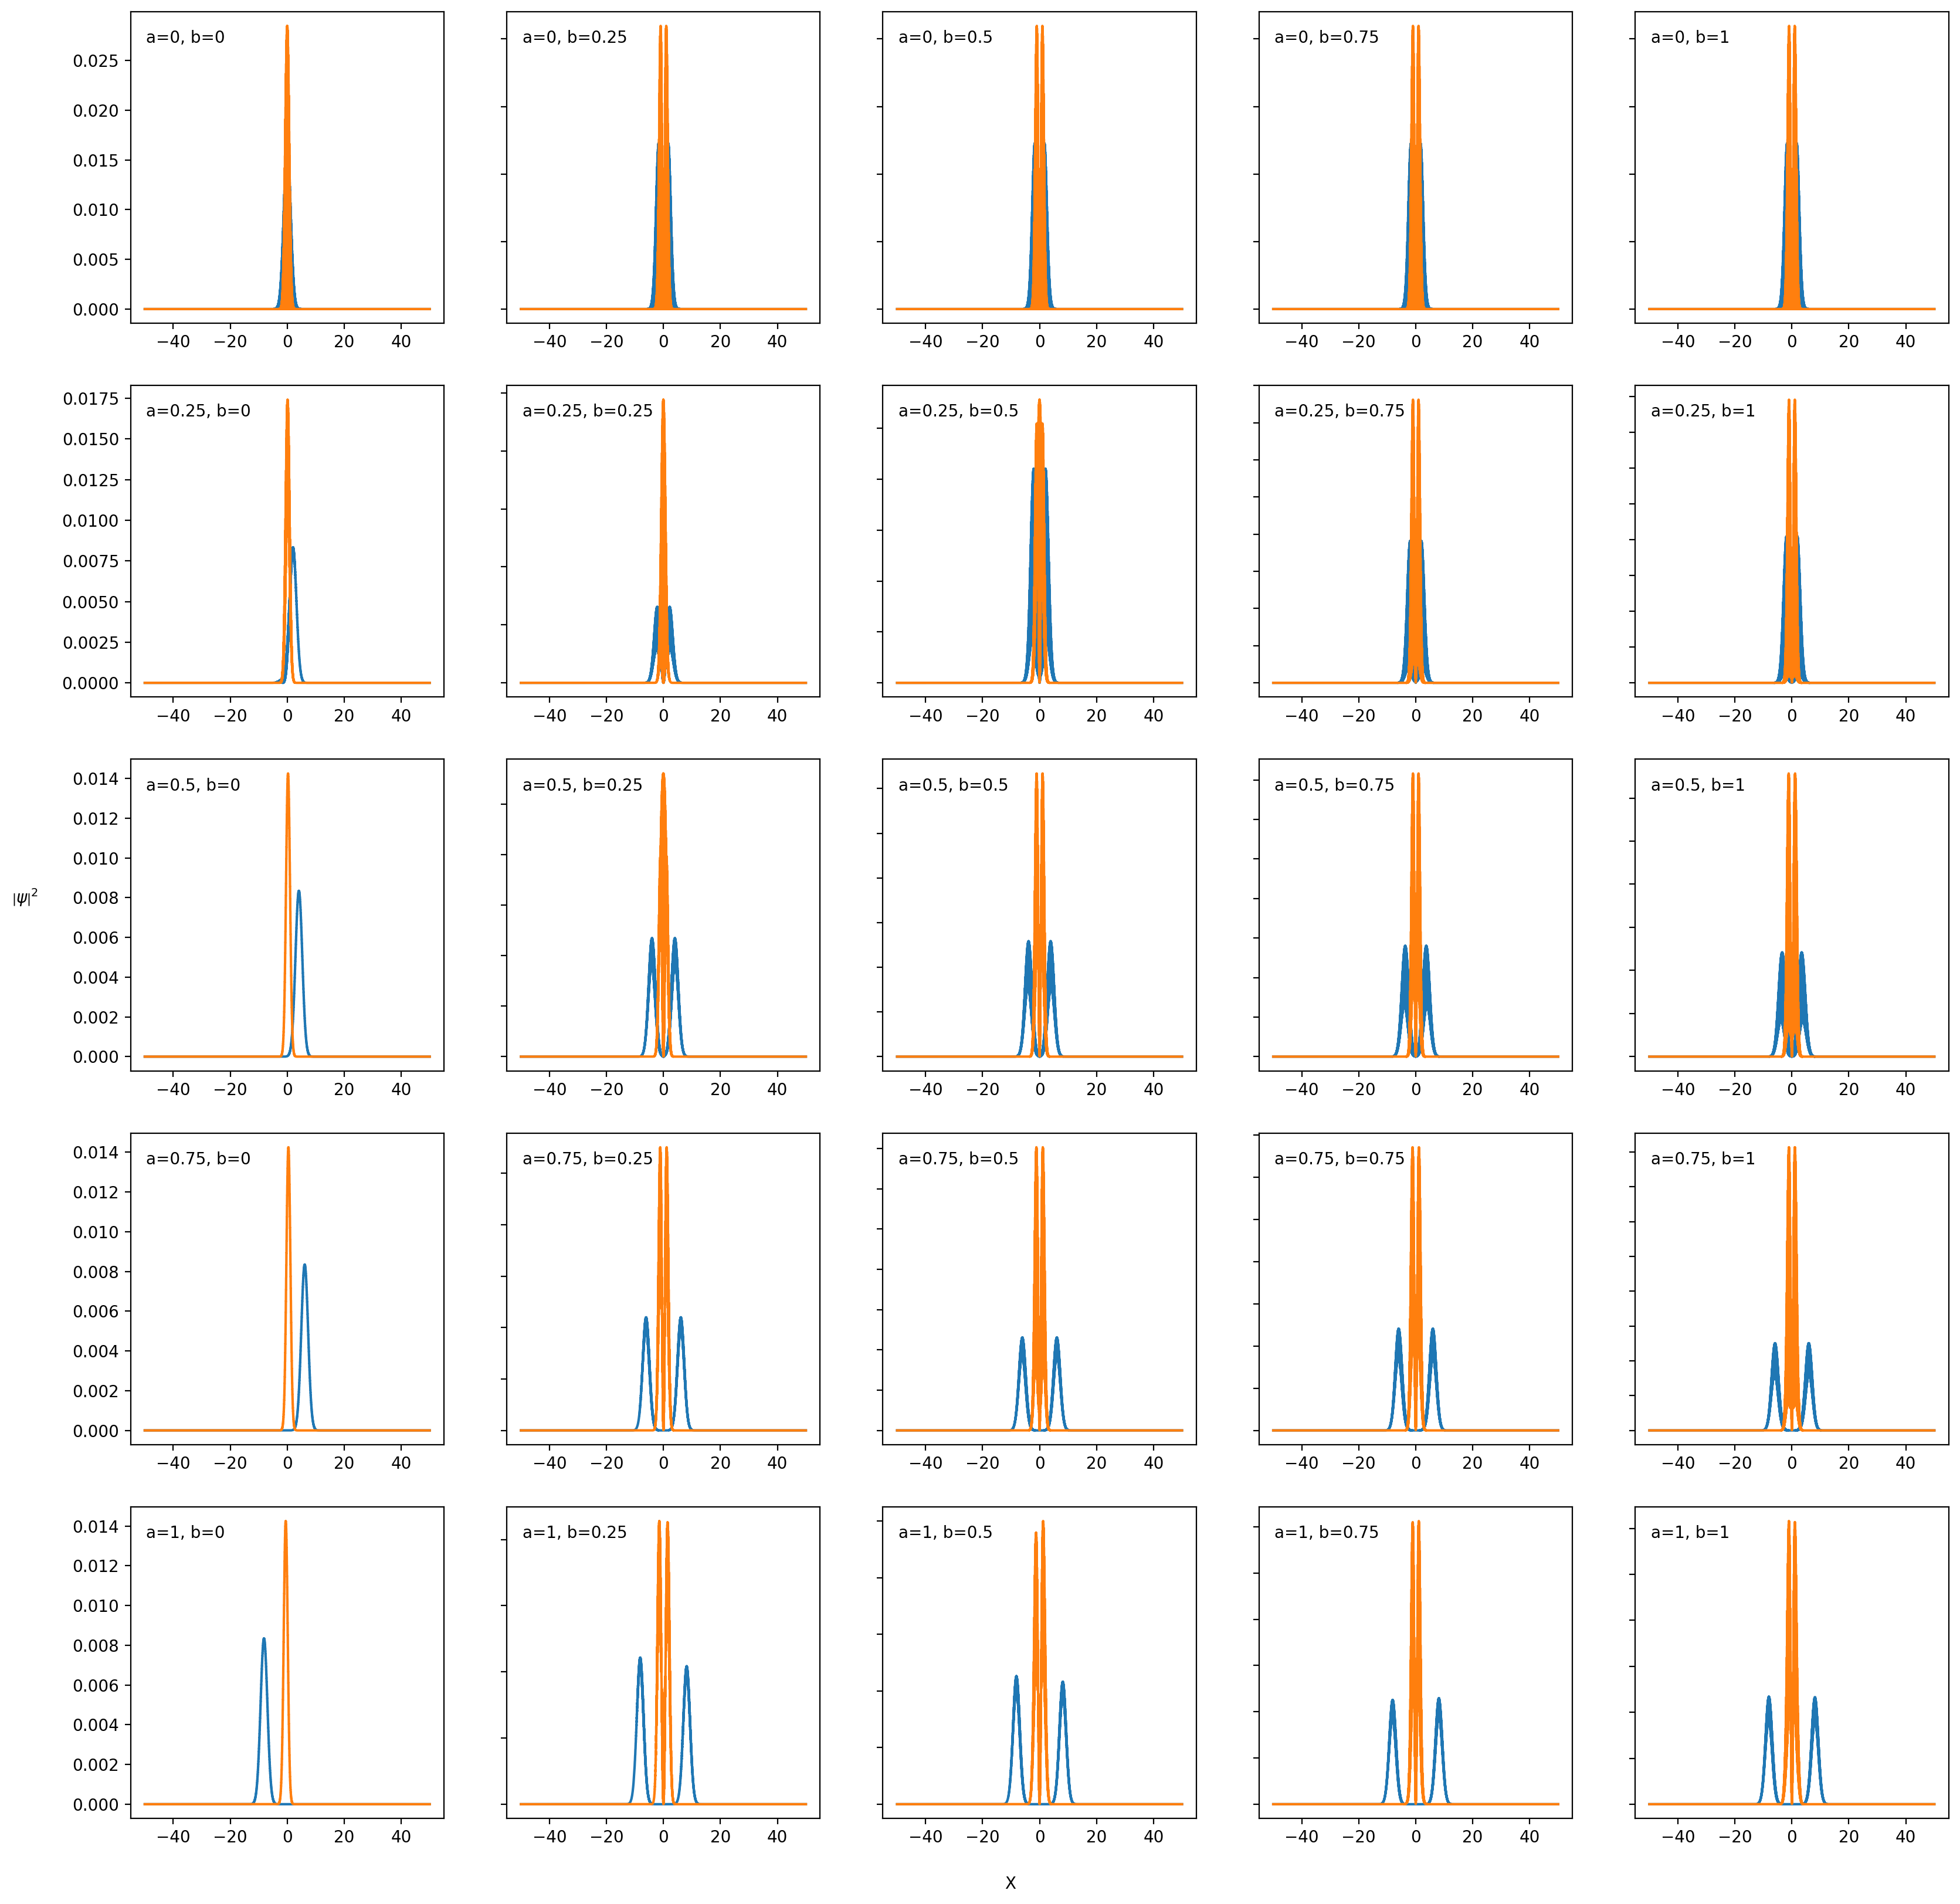

In [11]:
# spin up
def plot_graph(ax, a, b, v):
    ax.plot(X2, np.abs(psi[0,a,b][v])**2) 
    ax.plot(X2, np.abs(psit[a,b,v,100])**2)
    ax.text(0.05, 0.9, f'a={a}, b={b}', transform=ax.transAxes)

fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    
list=[0,0.25,0.5,0.75,1,5]
for i in range(5):
    for j in range(5):
        a = list[i]
        b = list[j]
        plot_graph(axs[i, j], a, b, 1)
        if j > 0: # remove y-axis labels for all subplots except the leftmost column
            axs[i, j].set_yticklabels([])
    # axs[i, 0].set_ylabel('$\\left|\\psi\\right|^2$')

fig.text(0.5, 0.08, 'X', ha='center')
fig.text(0.08, 0.5, '$\\left|\\psi\\right|^2$', ha='center')


plt.show()